# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#
# Project1 Find Road Lines in a Video
#

# Imports
import matplotlib.image as mpimg
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Pipeline to process an image and overlay Line annotations

Next Cal image: 0
Next Cal image: 1
Next Cal image: 2
Next Cal image: 3
Next Cal image: 4
Next Cal image: 5
Next Cal image: 6
Next Cal image: 7
Next Cal image: 8
Next Cal image: 9
Next Cal image: 10
Next Cal image: 11
Next Cal image: 12
Next Cal image: 13
Next Cal image: 14
Next Cal image: 15
Next Cal image: 16
Next Cal image: 17
Next Cal image: 18
Next Cal image: 19


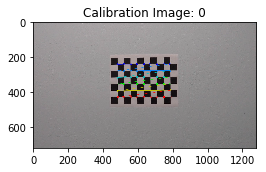

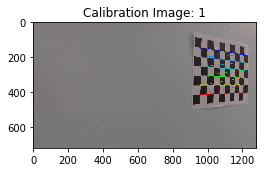

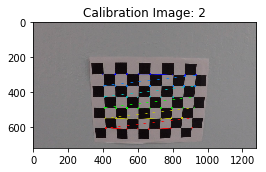

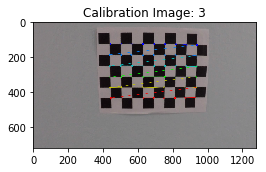

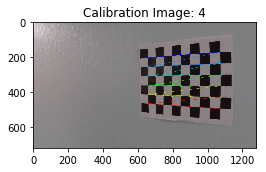

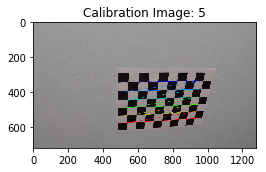

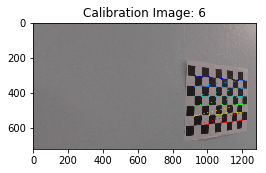

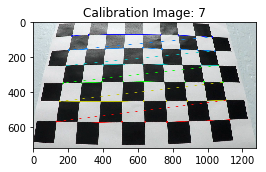

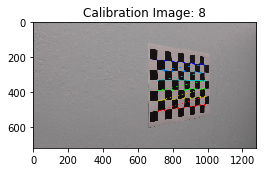

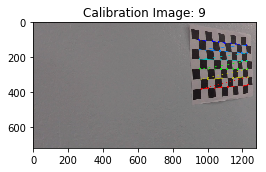

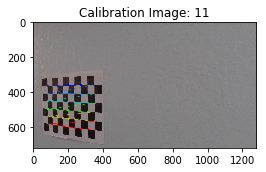

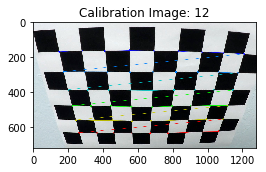

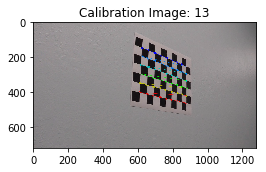

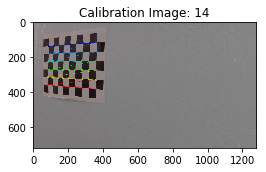

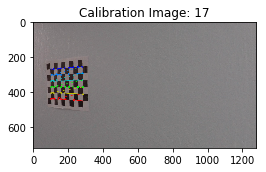

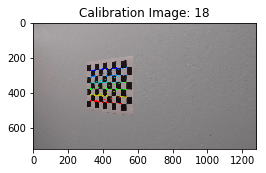

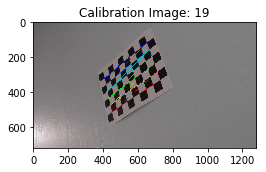

In [34]:
## Step 1. Perform camera calibration via chessboard method
nx = 9
ny = 6
cell_w = 1
cell_h = 20

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

def findCorners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        print("Next Cal image: " + str(idx))
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            fig, (img_box) = plt.subplots(1, 1, figsize=(4,4))
            img_box.imshow(img)
            plt.title("Calibration Image: " + str(idx))
            
findCorners()


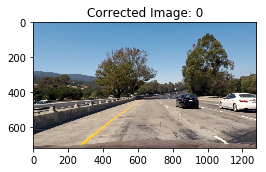

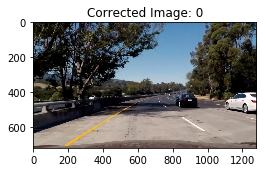

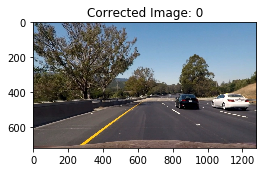

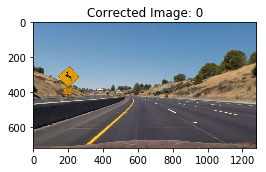

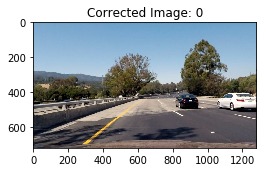

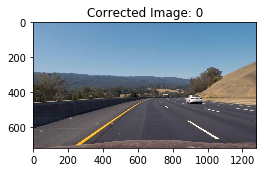

In [44]:
# Step 2. undistort images
import pickle
%matplotlib inline

def undistort_image(imgFile):
    img = cv2.imread(imgFile)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

processed_images = []
img_files = glob.glob('test_images/test*.jpg')
for imgFile in img_files:
    processed_images.append(undistort_image(imgFile))
    
    
for img in processed_images:    
    fig, (img_box) = plt.subplots(1, 1, figsize=(4,4))
    img_box.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Corrected Image: " + str(idx))
    


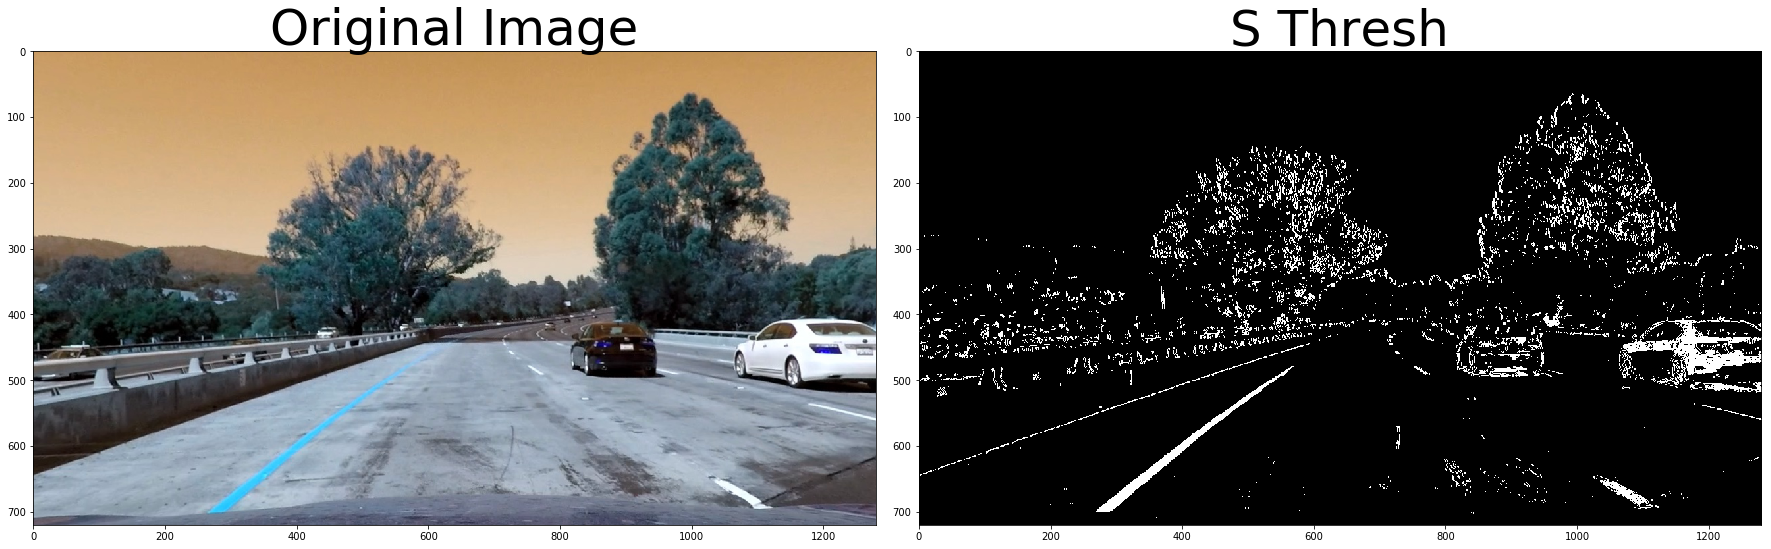

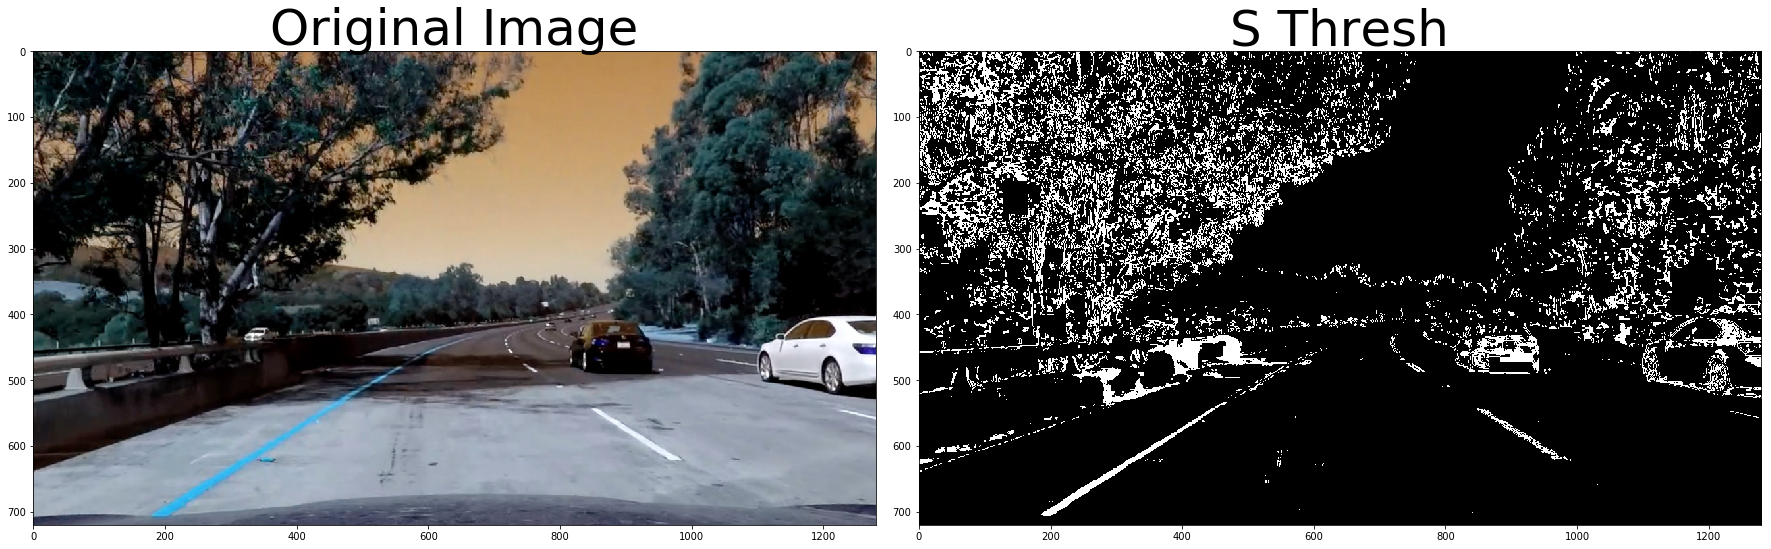

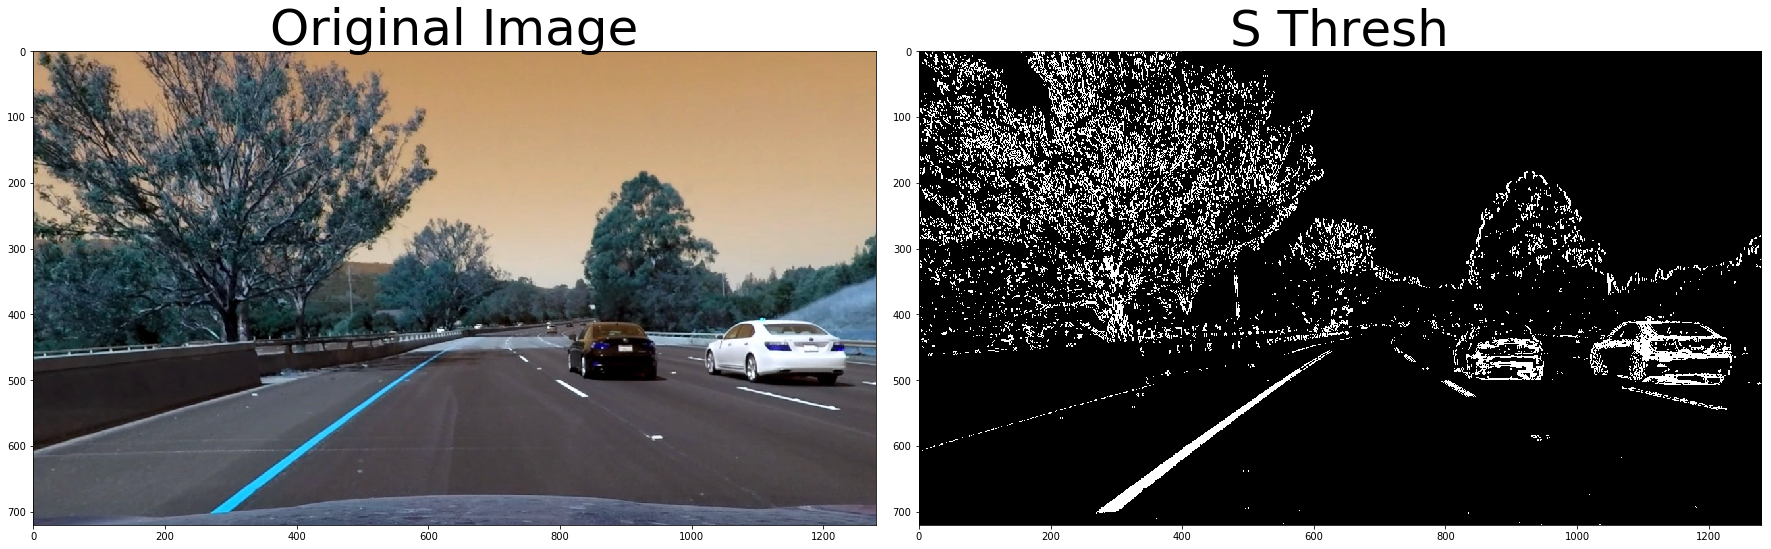

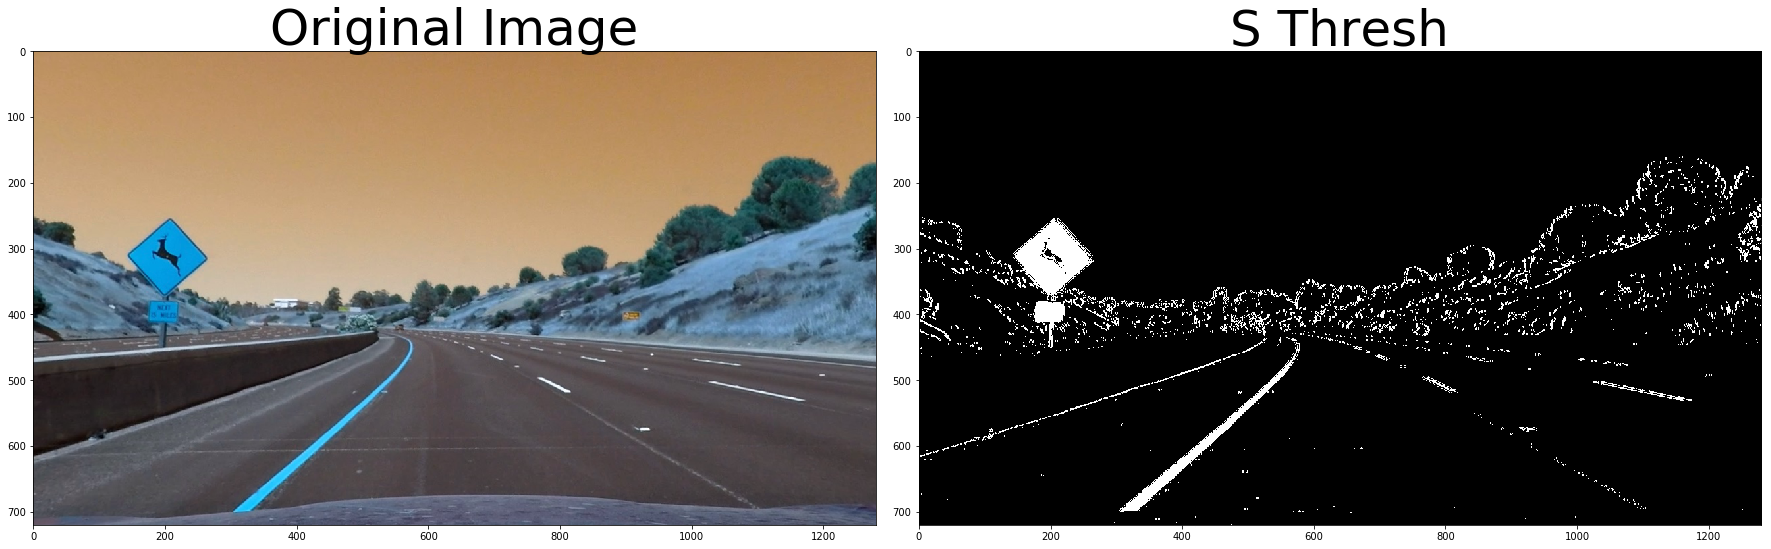

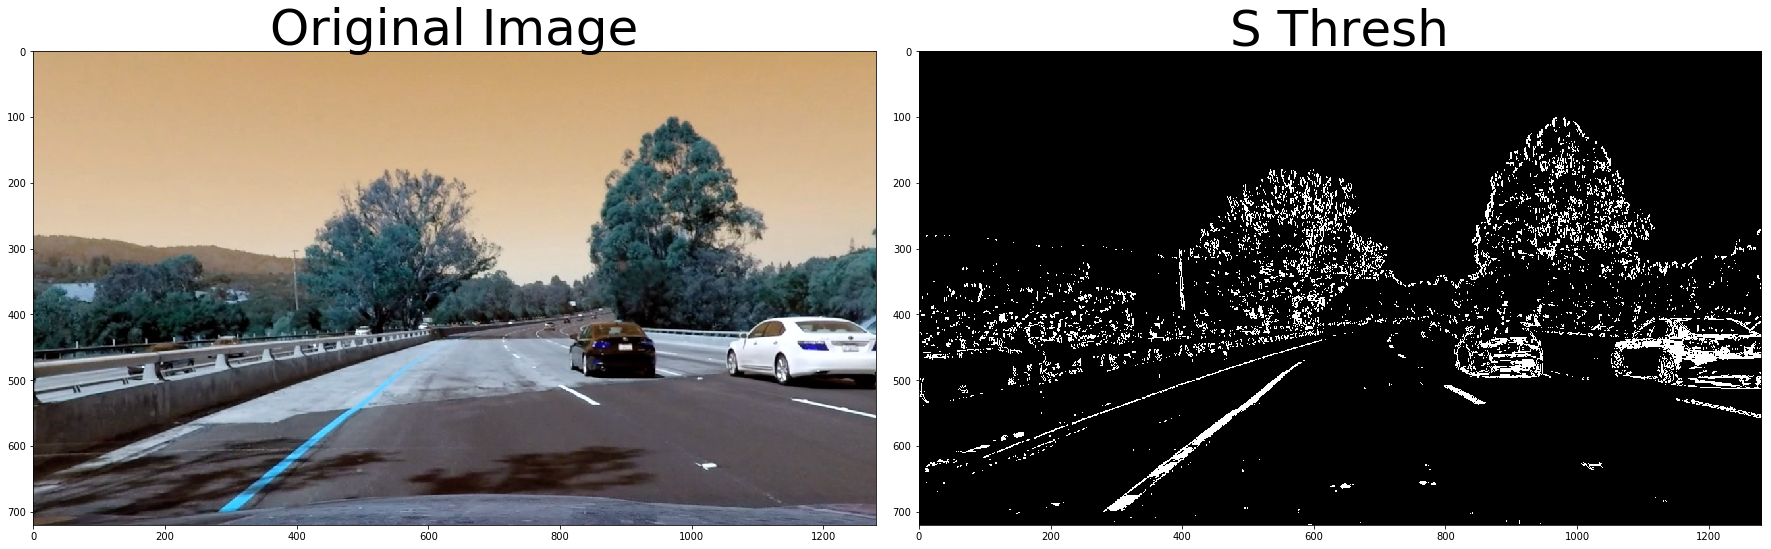

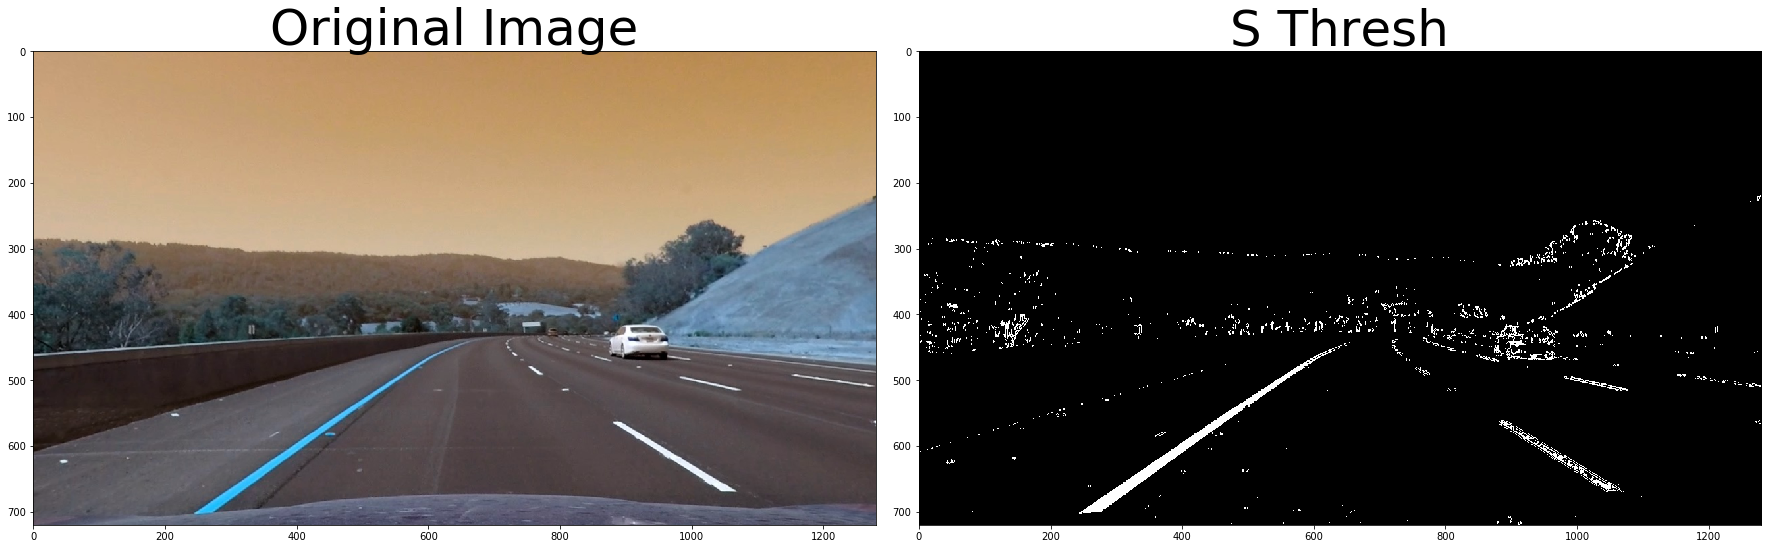

In [87]:
#Step 3. Use color transforms, gradients, etc., to create a thresholded binary image.

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def to_binary(img, s_thresh=(180, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = np.zeros_like(s_binary)
    color_binary[(sxbinary == 1) | (s_binary == 1)] = 1

    return color_binary


binary_images = []
for img in processed_images:
    hls_binary = hls_select(img, thresh=(180,255))
    #binary_images.append(hls_binary)
    img_binary = to_binary(img, s_thresh=(180,255), sx_thresh=(30, 90))
    binary_images.append(img_binary)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(img_binary, cmap='gray')
    ax2.set_title('S Thresh', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

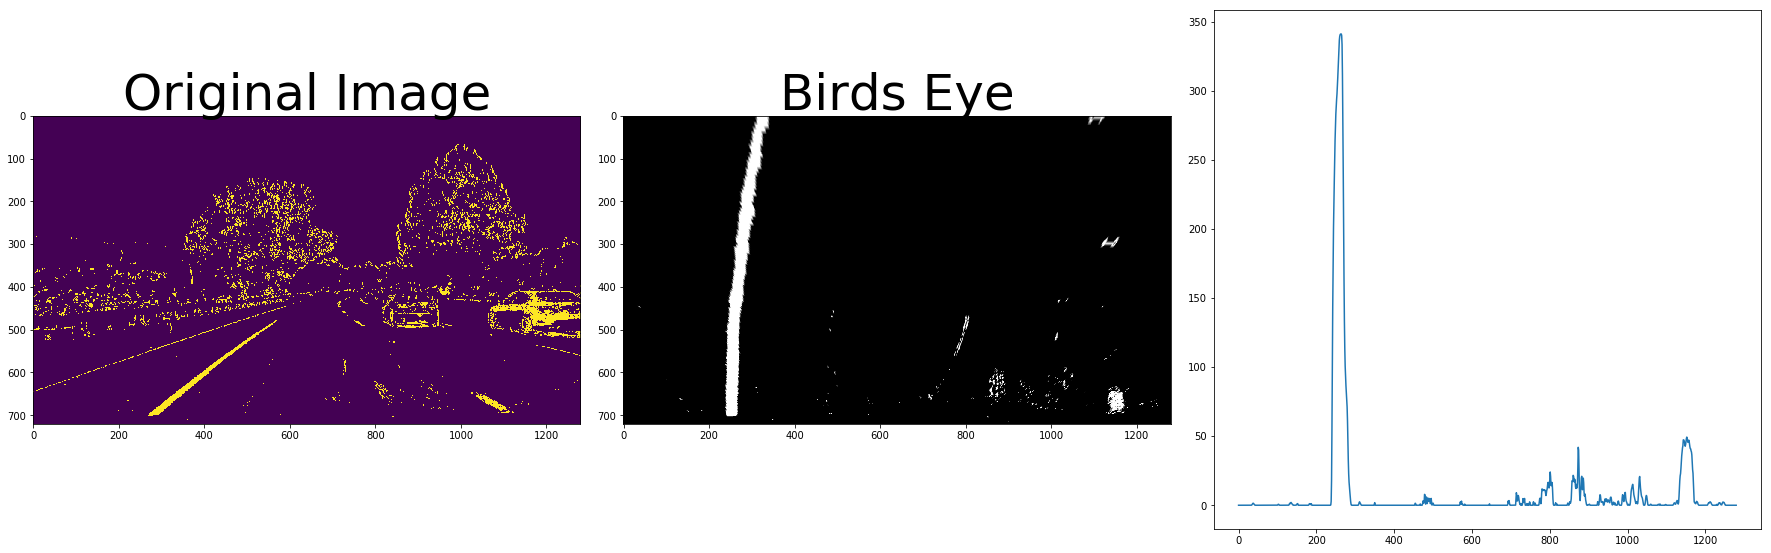

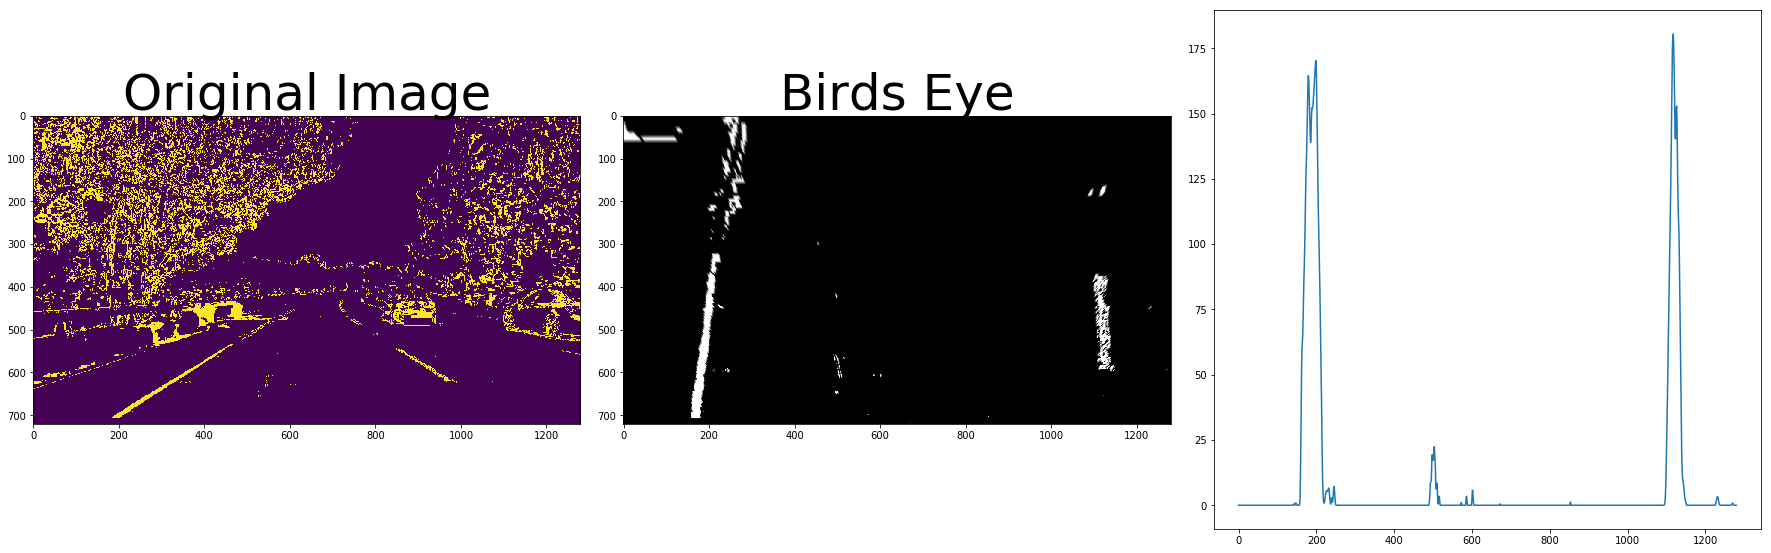

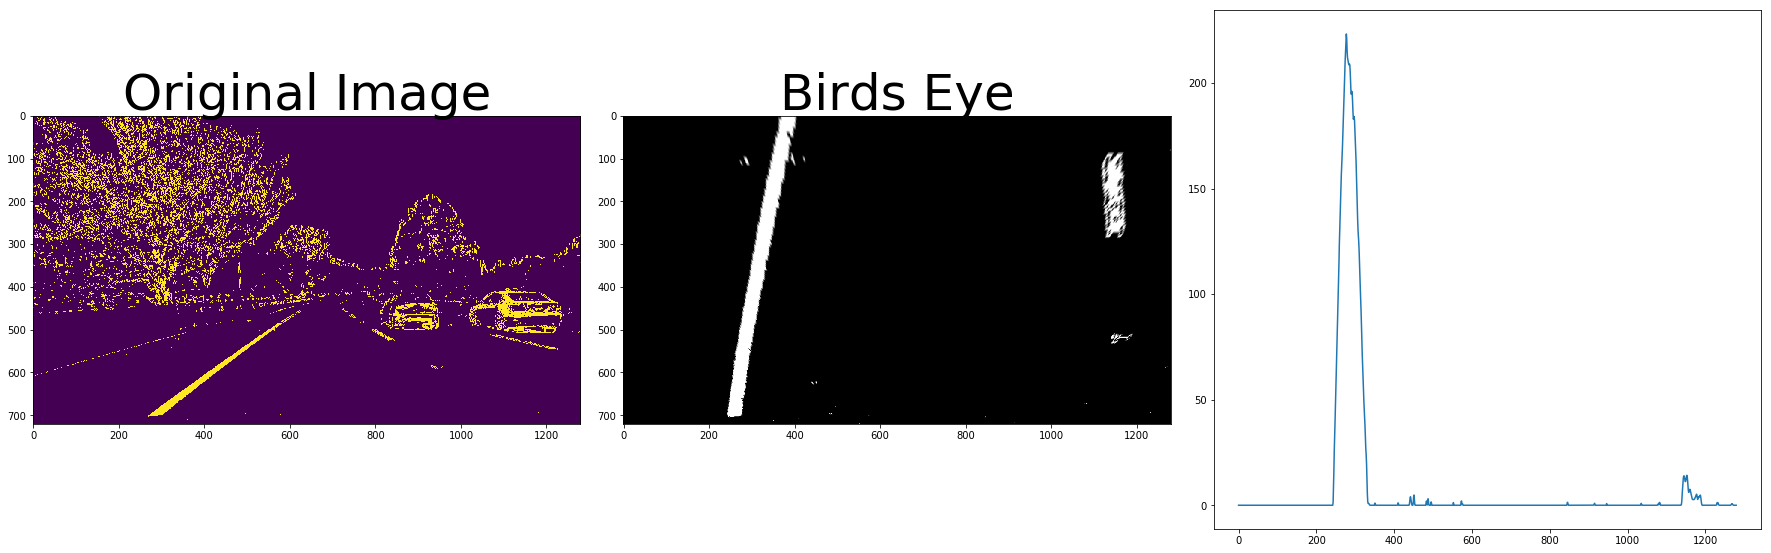

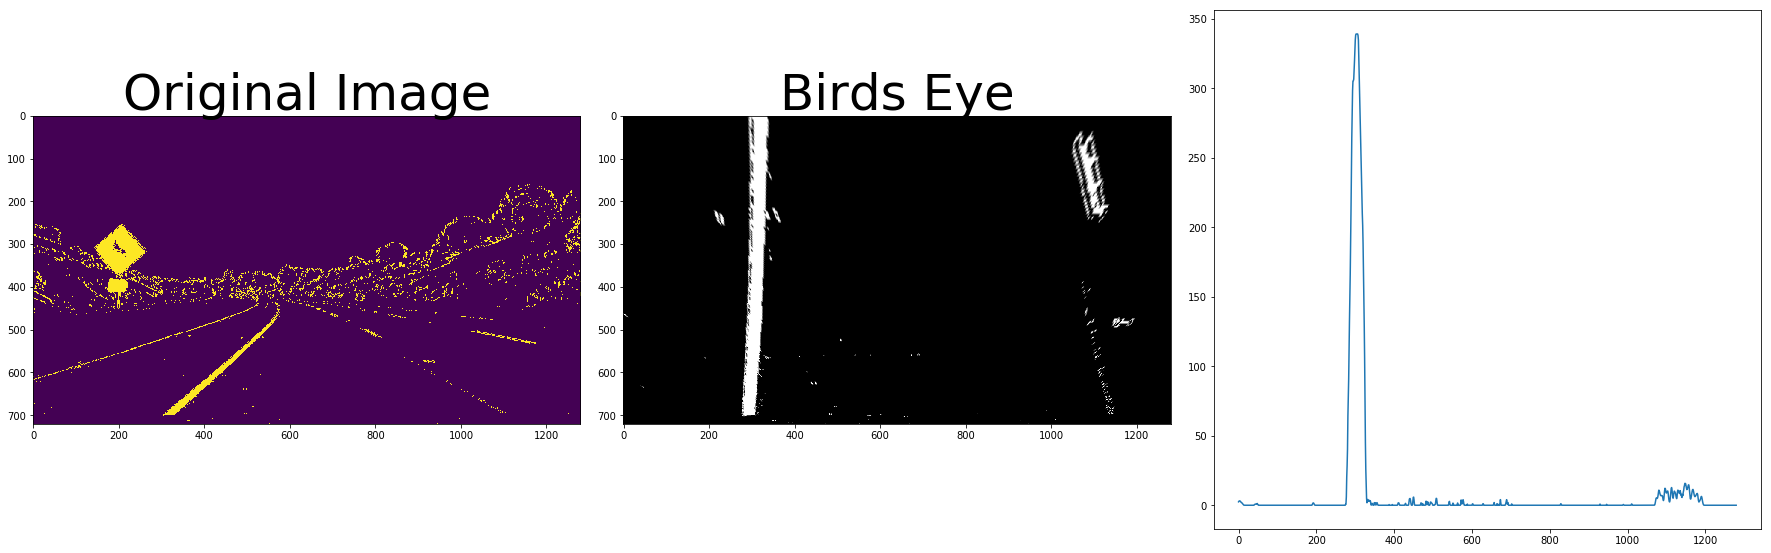

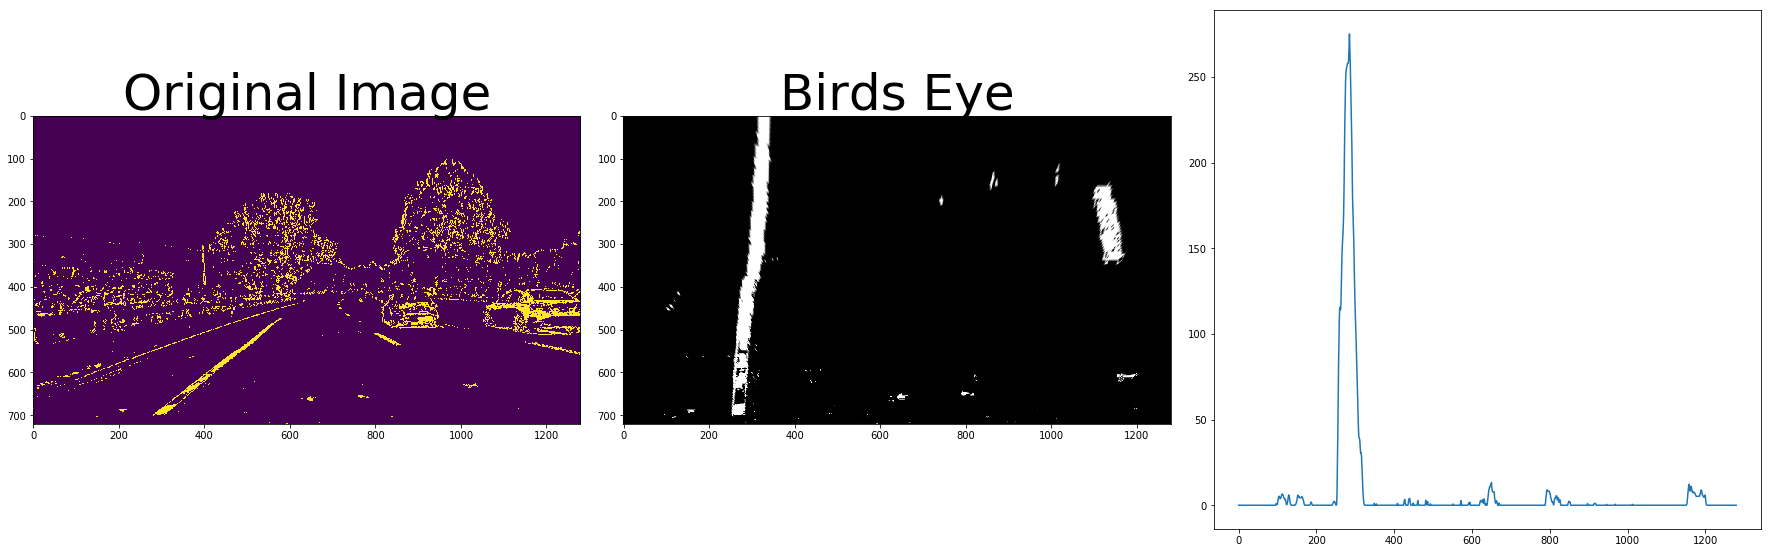

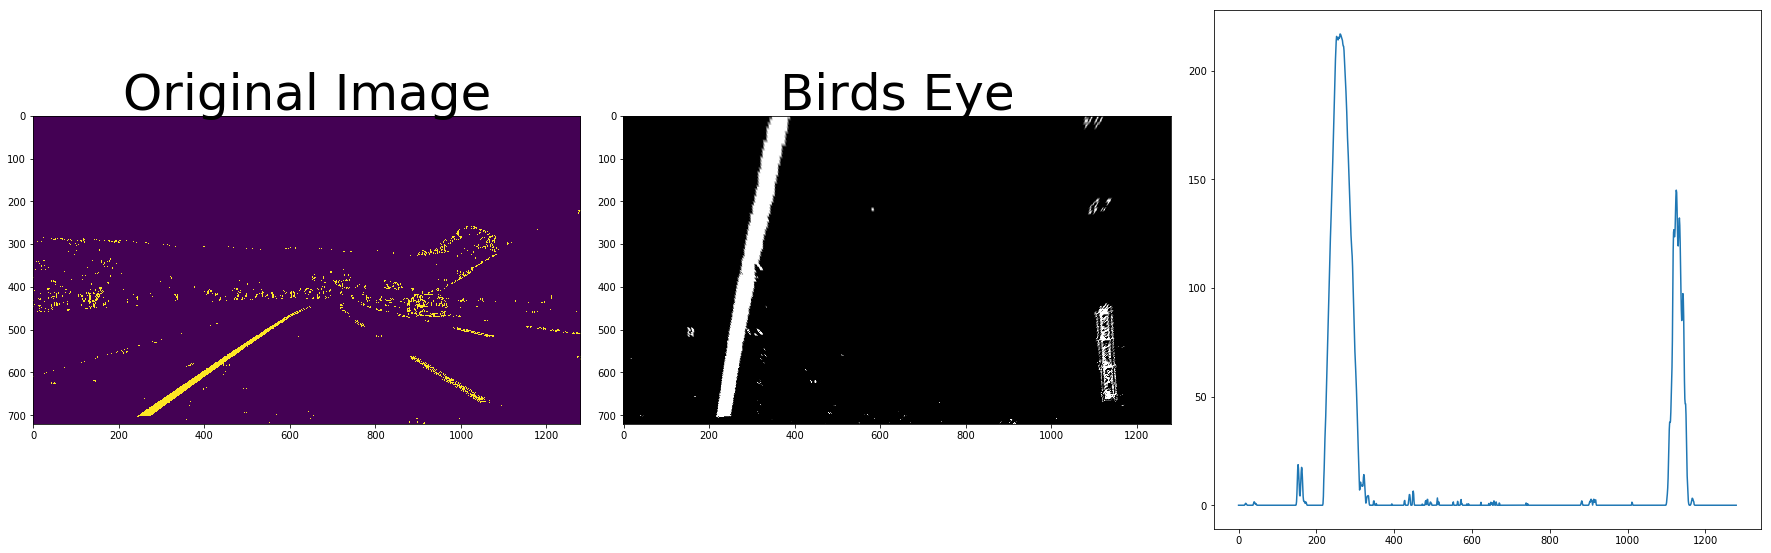

In [167]:
# Step 4: Apply a perspective transform to rectify binary image ("birds-eye view").
def to_birdseye(img):
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    
    #Taken off IMAGE 6
    src = np.float32([  [460, 490],[820, 490],[1260, 720], [40, 720] ])
    dst = np.float32([  [0, 0],[1280, 0],[1260, 720], [40, 720] ])

#    src = np.float32([  [460, 490],[820, 490],[1250, 720], [50, 720] ])
#    dst = np.float32([  [0, 0],[1280, 0],[1250, 720], [50, 720] ])

    
    M = cv2.getPerspectiveTransform(src, dst)
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img

birdseye_images = []
birdseye_color_images = []

for img in processed_images:
    birdseye_color_images.append(to_birdseye(img))

for img in binary_images:
    bin_img = to_birdseye(img)
    birdseye_images.append(bin_img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(bin_img, cmap='gray')
    ax2.set_title('Birds Eye', fontsize=50)
    histogram = np.sum(bin_img[bin_img.shape[0]//2:,:], axis=0)
    ax3.plot(histogram)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


1814.24197329 m 2513.3420409 m


ValueError: all the input array dimensions except for the concatenation axis must match exactly

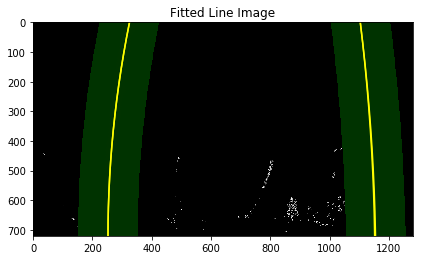

In [171]:
#Step 6: Detect lane pixels and fit to find the lane boundary.
left_fit = 0
right_fit = 0
g_left_lane_inds = []
g_right_lane_inds = []
g_left_fit = []
g_right_fit = []

# Create empty lists to receive left and right lane pixel indices
def fit_lanes(binary_warped, color_img):
    global g_left_lane_inds
    global g_right_lane_inds
    global g_left_fit
    global g_right_fit
    
    #left_lane_inds.clear()
    #right_lane_inds.clear()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.imshow(to_birdseye(color_img))
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    ax.set_title('Fitted Line Image')

    g_left_lane_inds = left_lane_inds
    g_right_lane_inds = right_lane_inds
    g_left_fit = left_fit
    g_right_fit = right_fit
    
    return out_img


def fill_poly(binary_warped, warped):
    global g_left_fit
    global g_right_fit

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (g_left_fit[0]*(nonzeroy**2) + g_left_fit[1]*nonzeroy + 
    g_left_fit[2] - margin)) & (nonzerox < (g_left_fit[0]*(nonzeroy**2) + 
    g_left_fit[1]*nonzeroy + g_left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (g_right_fit[0]*(nonzeroy**2) + g_right_fit[1]*nonzeroy + 
    g_right_fit[2] - margin)) & (nonzerox < (g_right_fit[0]*(nonzeroy**2) + 
    g_right_fit[1]*nonzeroy + g_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    g_left_fit = left_fit
    g_right_fit = right_fit

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(lefty)  # *ym_per_pix
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # rewarp back to vehicle position
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, lefty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, righty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)

#idx=0
#for img in birdseye_images:
#    line_img = fit_lanes(img, processed_images[idx])
#    idx += 1
    
img = birdseye_images[0]    
fit_lanes(img, processed_images[0])    
fill_poly(img, birdseye_color_images[0])





In [2]:
#
# find_road_lines takes a file path, reads an image and returns an image that is annotated by solid 
# yellow lines over the immediate road lines of a traveling vehicle from its 
# forward heading
#
def find_road_lines(image_path):
    imTmp = mpimg.imread(image_path)
    return find_road_lines_by_image(imTmp)

#
# find_road_lines_by_image takes a numpy image, and returns an image that is annotated by solid 
# yellow lines over the immediate road lines of a traveling vehicle from its 
# forward heading
#
def find_road_lines_by_image(image):

    ysize = image.shape[0]
    xsize = image.shape[1]
    original_image = image  # store image image for late use
 

    #
    # 1. Extract the white and yellow attributes of an image
    #

    # convert color image to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    #define white range
    lower_white = np.array([0,0,225], dtype=np.uint8)
    upper_white = np.array([255,20,255], dtype=np.uint8)

    #define yellow range
    lower_yellow = np.array([20,30,150], dtype=np.uint8)
    upper_yellow = np.array([50,160,255], dtype=np.uint8)

    #Create mask to image to white only
    maskWhite = cv2.inRange(hsv, lower_white, upper_white)

    #Create mask to image to yellow only
    maskYellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # bitwise the image to extract only white and yellow attributes
    img1 = cv2.bitwise_and(original_image,image, mask= maskWhite)
    img2 = cv2.bitwise_and(original_image,image, mask= maskYellow)

    # overlay the white and yellow attributes into one image
    image = cv2.add(img1,img2)

    #
    # 2. Use blur, canny, and hough to extact the solid lines of the road
    #
    
    # convert to grayscale
    image_gray = grayscale(image)

    # blur the image to get some solid fill and remove noise
    kernel_size = 11
    image = gaussian_blur(image_gray, kernel_size)

    # Apply Canny to extract edges
    low_threshold = 50
    high_threshold = 150
    edges = canny(image, low_threshold, high_threshold)


    # Crop area we are interested in, this is the trapazoid area in front of a car
    # as its non-holonomic, array always in LL, UL, UR, LR
    vertices = np.array([[(0,ysize*.95),(xsize * 0.42, ysize*0.55), (xsize * 0.58, ysize*0.55), (xsize, ysize*.95)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # get the hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    #
    # Here you should have the outlines of road lines
    # Now draw solid lines over these elements on the original image
    #
    color_edges = np.dstack((edges, edges, edges)) 
    image = weighted_img(original_image, line_image)

    return image


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
# Following functions are Helper functions

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#
# Globals for the following function
#

g_r_slope = 0
g_l_slope = 0
g_r_intp = 0
g_l_intp = 0
upper_boundary_y = 400
run_once = False

def draw_solid_lines(img, lines, color=[255, 255, 0], thickness=10):
    gain_new = 0.3
    gain_old = 0.7
    a_slope = []
    a_int = []
    b_slope = []
    b_int = []
    farRightX = 0
    farLeftX = 0
    farRightY = 0
    farLeftY = 0
    global g_r_slope
    global g_l_slope
    global g_r_intp 
    global g_l_intp
    global upper_boundary_y
    global run_once

    rN = 1
    lN = 1
    x1RAvg = 0
    y1RAvg = 0
    x1LAvg = 0
    y1LAvg = 0
    x2RAvg = 0
    y2RAvg = 0
    x2LAvg = 0
    y2LAvg = 0


    # 
    # Create a blend filter so the line, slope change is not noisy
    # This initializes the filter parameters by drawing the first valid slope
    # quickly and not off the image (when the iniital slope is 0)
    #
    if lines is None and g_l_slope is not 0 and g_r_slope is not 0 :
        startY = upper_boundary_y
        endY = 800
        startX = int((startY - g_l_intp) / g_l_slope)
        endX = int((endY - g_l_intp) / g_l_slope)
        cv2.line(img, (startX, startY), (endX, endY), color, thickness)            
        startY = upper_boundary_y
        endY = 800
        startX = int((startY - g_r_intp) / g_r_slope)
        endX = int((endY - g_r_intp) / g_r_slope)
        cv2.line(img, (startX, startY), (endX, endY), color, thickness)            
        return

    # For each line, calculate the slope
    # if the slope is negative its a line right of the vehicle
    # if the slope is positive its a line left of the vehicle
    for line in lines:
        for x1,y1,x2,y2 in line:
            inf_check = x2-x1
            if inf_check == 0:
                break;
            else:    
                m = ((y2-y1)/(inf_check))

             # Use a average of all points in x and y directions
             # to deterimine average slope.
             # organize the calculation by sorting the left line slopes
             # and the right line slopes
                
            if m < 0:  # right side 
                x1RAvg = x1RAvg + (x1 - x1RAvg)/rN
                x2RAvg = x2RAvg + (x2 - x2RAvg)/rN
                y1RAvg = y1RAvg + (y1 - y1RAvg)/rN
                y2RAvg = y2RAvg + (y2 - y2RAvg)/rN
                rN += 1
            
            elif m > 0: # left side
                x1LAvg = x1LAvg + (x1 - x1LAvg)/lN
                x2LAvg = x2LAvg + (x2 - x2LAvg)/lN
                y1LAvg = y1LAvg + (y1 - y1LAvg)/lN
                y2LAvg = y2LAvg + (y2 - y2LAvg)/lN
                lN += 1
    
    # If there is no line and/or a single point was found, skip it, bad frame...
    if rN < 2:
        return
    if lN < 2:
        return
    
    # Get the line of the two average slopes
    [r_slope, r_intercept] = np.polyfit([x1RAvg, x2RAvg], [y1RAvg, y2RAvg], 1)
    [l_slope, l_intercept] = np.polyfit([x1LAvg, x2LAvg], [y1LAvg, y2LAvg], 1)

    # Populate the blend filter 
    if run_once is False:
        g_r_slope = r_slope
        g_l_slope = l_slope
        g_r_intp = r_intercept
        g_l_intp = l_intercept
        run_once = True
        return
    
    # After init, calcuate the new slope and intp via blend filter
    if abs(g_l_slope - l_slope) < 0.1:
        g_l_slope = gain_new * l_slope + gain_old * g_l_slope
        g_l_intp = gain_new * l_intercept + gain_old * g_l_intp
        
        
    # Find the end points of a line using arbitarty y values
    # in our case it's the lower half of the scene as you are looking out a
    # vehicle windshield
    startY = upper_boundary_y
    endY = 800  # ASSUME image does no excess 800 pixels in height (720p max)
    startX = int((startY - g_l_intp) / g_l_slope)
    endX = int((endY - g_l_intp) / g_l_slope)

    # draw left line
    cv2.line(img, (startX, startY), (endX, endY), color, thickness)            

    if abs(g_r_slope - r_slope) < 0.1:
        g_r_slope = gain_new * r_slope + gain_old * g_r_slope
        g_r_intp = gain_new * r_intercept + gain_old * g_r_intp

    startY = upper_boundary_y
    endY = 800
    startX = int((startY - g_r_intp) / g_r_slope)
    endX = int((endY - g_r_intp) / g_r_slope)

    # draw right line
    cv2.line(img, (startX, startY), (endX, endY), color, thickness)            
    

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_solid_lines(line_img, lines)

    # NIU    
    # draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
#
# Test 1
#
import os
image_path_list = os.listdir("test_images/")
print(image_path_list)

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
#
# Test 2, use smaple photos and see if the line drawing works
#
import scipy.misc

for path_str in image_path_list:
    
    print("analyzing: " + path_str)
    processed_image = find_road_lines("test_images/" + path_str)
    output_file_path = "test_images_output/" + path_str 
    output_file_path = output_file_path.replace("jpg", "png")
    mpimg.imsave(output_file_path , processed_image)
    

analyzing: solidWhiteCurve.jpg
analyzing: solidWhiteRight.jpg
analyzing: solidYellowCurve.jpg
analyzing: solidYellowCurve2.jpg
analyzing: solidYellowLeft.jpg
analyzing: whiteCarLaneSwitch.jpg


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    return find_road_lines_by_image(image)


Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
upper_boundary_y = 325  #We noitce the FOV of the car is decent
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 10.8 s, sys: 279 ms, total: 11.1 s
Wall time: 8.64 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""

<video width="640" height="480" controls>
  <source src="test_videos_output/solidWhiteRight.mp4" type="video/mp4">
</video> 
""")

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
upper_boundary_y = 325   #We noitce the FOV of the car is bad
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:27<00:00, 25.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 35.3 s, sys: 600 ms, total: 35.9 s
Wall time: 28.4 s


In [11]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
upper_boundary_y = 475   #We noitce the FOV of the car is bad
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:18<00:00, 14.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 18.7 s, sys: 344 ms, total: 19 s
Wall time: 20.9 s


In [13]:
HTML("""
<video width="640" height="480" controls>
  <source src="{0}">
</video>
""".format(challenge_output))